# J2_VOP 

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Initial-value-problem:-J2-problem-(in-physical-time)">
              Initial value problem: J2-problem (in physical time)</a></li>
    
<li><a href="#Initial-value-problem:-VOP-formulation-of-$J_2$-KS-equation">
              Initial value problem: VOP formulation of $J_2$-KS equation</a></li>

<li><a href="#Errors-in-energy">Errors in energy</a></li>
    
<li><a href="#Errors-in-position">Errors in position</a></li>

</ul>  

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq
using JLD2, FileIO
using Parameters,NBInclude
#using IRKGaussLegendre
using LaTeXStrings
using BenchmarkTools

In [2]:
PATH_DATA="./Data/"

PATH_SRC="../../src_simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   


PATH_SRC="../../src_seq/"
include(string(PATH_SRC,"IRKGL_SEQ.jl"))
using .IRKGL_SEQ  


PATH_SRC="../../src/"
include(string(PATH_SRC,"MyBenchmarksTools.jl"))

launch_method_tests (generic function with 1 method)

In [3]:
PATH_SRC2="../../src_seq2/"
include(string(PATH_SRC2,"IRKGL_SEQ.jl"))

PATH_SRC2="../../src_simd2/"
include(string(PATH_SRC2,"IRKGL_SIMD.jl"))

using .IRKGL_SEQ2
using .IRKGL_SIMD2

In [4]:
nruns=100

100

##### <a href="#top">Hasierara</a>

## Initial value problem: J2-problem (in physical time)

In [5]:
PATH_ODES="../../ODEProblems/"
include(string(PATH_ODES,"J2_PhysicalTime.jl"));


In [6]:
# Geostationary satellite (Montenbruck 116.orr)
q0 = [4.21491336e4,0.0,0.0]                            # km
v0 = [0.0, 3.075823259987749,0.0010736649055318406 ]   # km

u0 = vcat(q0,v0)
dim=length(size(u0))


μ = 398600.8
Re = 6378.135
ϵ = 0.0010826157
p =  [μ, Re, ϵ]

u0_B=BigFloat.(u0)
p_B=BigFloat.(p)
E0 = Energy(u0_B,p_B)

-4.726687902988031339433948214809857854784194755950509104788100277222934907667882

In [7]:
s=8

t0 = 0.
birak = 100
T = 86169.546163670
tF = birak*T
tF = 1e8
tspan=(t0,tF)
prob = ODEProblem(J2ODE!, u0, tspan, p);

In [8]:
dt0 = (tF-t0)/(200*birak)
m=50
println("dt = $dt0,  m=$m")

alg=IRKNGL_simd(s=s, initial_interp=1, m=m, myoutputs=true)
sol0,iters0,steps0=solve(prob, alg, dt=dt0, adaptive=false);

dt = 5000.0,  m=50


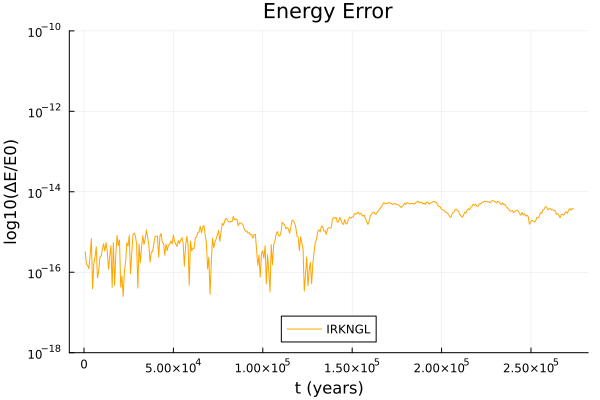

In [9]:
E0=Energy(u0_B,p_B)
year=365.25
yrange=(1e-18,1e-10)
ΔE0 = map(x->Energy(BigFloat.(x),p_B), sol0.u)./E0.-1

plot(title="Energy Error",xlabel="t (years)", ylabel="log10(ΔE/E0)", 
     yscale=:log10, ylims=yrange, legend=:bottom)
plot!(sol0.t./year,abs.(ΔE0),label="IRKNGL", color="orange")




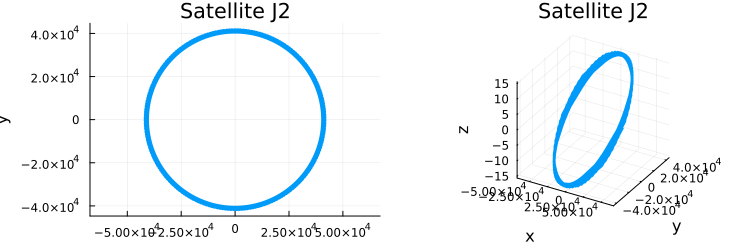

In [10]:
xx = [u[1] for u in sol0.u]
yy = [u[2] for u in sol0.u]
zz = [u[3] for u in sol0.u]
pl1=plot(xx,yy, aspect_ratio=1, title="Satellite J2", legend=false, xlabel="x", ylabel="y")
pl2=plot(xx,yy,zz, aspect_ratio=1, title="Satellite J2", legend=false, xlabel="x", ylabel="y", zlabel="z")

plot(pl1,pl2, layout=(1,2), size=(750,250))

##### <a href="#top">Back to the top</a>

## Initial value problem: VOP formulation of $J_2$-KS equation


In [11]:
PATH_ODES="../../ODEProblems/"

@nbinclude(string(PATH_ODES,"J2_VOP.ipynb"));

In [12]:
h = μ/norm(q0) - 0.5*dot(v0,v0) -  V(q0) 
ω = sqrt(h/2)

u0 = χ(q0)
V0 = vcat(v0,[0.])
w0 = 0.5*L(u0)' * V0
r0 = norm(q0)

dim=length(size(u0))

# Konprobazioa:
(norm(L(u0)*u0 - vcat(q0,[0.])), norm(r0*V0 - 2* L(u0) * w0))

(7.275957614183426e-12, 1.7390022135239662e-11)

In [13]:
Ifcn(u0,w0)

0.0

### VOP formulation




In [14]:
α0 = u0
β0 = w0
U0 = vcat(α0, β0)
μ = 398600.8
h = μ/norm(q0) - 0.5*dot(v0,v0) -  V(q0)
ω = sqrt(h/2)
C = 1.7554962315534863e10
p = [C, ω, μ];

### Integration parameters

In [15]:
s=8

t0 = 0.
sasi_periodo = 2*π/ω
sasi_periodo = 6/ω
dt = sasi_periodo*2.1
tF = 20000*sasi_periodo
tF = 2*2000*sasi_periodo

n = 1000

dt = 2.
m = convert(Int64,ceil(abs(tF-t0)/(n*dt)))

n = convert(Int64,ceil(abs(tF-t0)/(m*dt))) # Number of macro-steps (Output is saved for n+1 time values)
dt = (tF-t0)/(n*m)
println("dt = $dt, n=$n, m=$m")

prob = ODEProblem(J2VOPODE!, U0, (t0,tF), p)

tspan_B=(BigFloat(t0),BigFloat(tF))
U0_B=BigFloat.(U0)
p_B=BigFloat.(p)

prob_B = ODEProblem(J2VOPODE!, U0_B, tspan_B, p_B);

dt = 1.999438135551524, n=976, m=8


##### <a href="#top">Back to the top</a>

## Integrations

### IRKGL_simd (urrats finkoa)

In [16]:
#dt=0.05
alg1=IRKGL_Seq(s=8, initial_interp=1, m=m,  myoutputs=true)
alg2=IRKGL_simd(s=8, initial_interp=1, m=m,  myoutputs=true)

sol1,iters1,steps1=solve(prob,alg1,dt=dt, adaptive=false)
sol2,iters2,steps2=solve(prob,alg2,dt=dt, adaptive=false);

sol11,iters11,steps11=IRKGL_simd_2(prob.u0, dt, prob.tspan[1], prob.tspan[2], prob.f, prob.p; 
                                   s=8,m=m,initial_interp=1,myoutputs=true);

In [17]:
solve(prob,alg1,dt=dt, save_everystep=false, adaptive=false);
cpu_IRKGLseq=0.
for i in 1:nruns
    cpu_IRKGLseq+=@elapsed solve(prob,alg1,dt=dt, save_everystep=false, adaptive=false);
end
cpu_IRKGLseq=cpu_IRKGLseq/nruns

solve(prob,alg2,dt=dt,save_everystep=false, adaptive=false);
cpu_IRKGLsimd=0.
for i in 1:nruns
    cpu_IRKGLsimd+=@elapsed solve(prob,alg2,dt=dt, save_everystep=false, adaptive=false);
end
cpu_IRKGLsimd=cpu_IRKGLsimd/nruns;


IRKGL_simd_2(prob.u0, dt, prob.tspan[1], prob.tspan[2], prob.f, prob.p; save_everystep=false);
cpu_IRKGLsimd_2=0.
for i in 1:nruns
    cpu_IRKGLsimd_2+=@elapsed IRKGL_simd_2(prob.u0, dt, prob.tspan[1], prob.tspan[2], prob.f, prob.p; 
                                           save_everystep=false);
end
cpu_IRKGLsimd_2=cpu_IRKGLsimd_2/nruns;

### Vern9 (urrats finkoa)

In [18]:
dt_Vern9 = dt/2
sol3 =solve(prob,Vern9(), dt=dt_Vern9,  adaptive=false);


In [19]:
solve(prob,Vern9(), dt=dt_Vern9, save_everystep=false, adaptive=false);
cpu_Vern9=0.
for i in 1:nruns
    cpu_Vern9+=@elapsed solve(prob,Vern9(), dt=dt_Vern9, save_everystep=false, adaptive=false);
end
cpu_Vern9=cpu_Vern9/nruns;

<a href="#top">Back to the top</a>

## Errors in energy

In [22]:
println("CPU IRKNGL_seq=$cpu_IRKGLseq, CPU IRKNGL_simd=$cpu_IRKGLsimd, CPU IRKNGL_simd_2=$cpu_IRKGLsimd_2")
println("CPU CPU IRKNGL_seq/CPU IRKNGL_simd=$(cpu_IRKGLseq/cpu_IRKGLsimd) ")
println("CPU Vern9=$cpu_Vern9" )

CPU IRKNGL_seq=0.03834621732, CPU IRKNGL_simd=0.009730303069999998, CPU IRKNGL_simd_2=0.01016158349
CPU CPU IRKNGL_seq/CPU IRKNGL_simd=3.9409067779427356 
CPU Vern9=0.01006402347


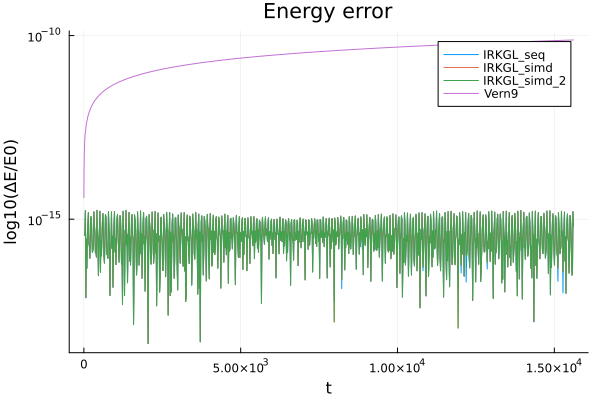

In [21]:
E0=J2VOPEnergy(U0_B,p_B, BigFloat(sol1.t[1]))

uu1=sol1.u[2:end]
tt1=sol1.t[2:end]
ΔE1= map((x,t)->J2VOPEnergy(BigFloat.(x),p_B, BigFloat(t)), uu1,tt1)./E0.-1

uu2=sol2.u[2:end]
tt2=sol2.t[2:end]
ΔE2= map((x,t)->J2VOPEnergy(BigFloat.(x),p_B, BigFloat(t)), uu2,tt2)./E0.-1

uu11=sol11.u[2:end]
tt11=sol11.t[2:end]
ΔE11= map((x,t)->J2VOPEnergy(BigFloat.(x),p_B, BigFloat(t)), uu11,tt11)./E0.-1

uu3=sol3.u[2:end]
tt3=sol3.t[2:end]
ΔE3= map((x,t)->J2VOPEnergy(BigFloat.(x),p_B, BigFloat(t)), uu3,tt3)./E0.-1

plot(title="Energy error", yscale=:log10, xlabel="t", ylabel="log10(ΔE/E0)")
plot!(tt1,abs.(ΔE1), yscale=:log10,  label="IRKGL_seq")
plot!(tt2,abs.(ΔE2), yscale=:log10,  label="IRKGL_simd")
plot!(tt11,abs.(ΔE11), yscale=:log10,  label="IRKGL_simd_2")
plot!(tt3,abs.(ΔE3), yscale=:log10,  label="Vern9")